<a href="https://colab.research.google.com/github/cagBRT/PointCloud/blob/main/Image_to_Point_Cloud_with_Point_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://segments.ai/blog/image-to-pointcloud-with-point-e


#  Point-E
Point-E is a deep learning model created by OpenAI that transforms a text caption into a colored point cloud. More specifically, Point-E consists of three steps, each handled by a dedicated ML model:

Generate an image conditioned on a text caption
Create a point cloud (1024 points) conditioned on the image
Upsample the point cloud (to 4096 points) conditioned on the image and low-resolution point cloud

In [1]:
!pip install git+https://github.com/openai/point-e -q

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.6 MB/s eta 0:00:00


In [2]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print("Creating base model")
base_name = "base300M"  # Use base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

Creating base model


100%|████████████████████████████████████████| 890M/890M [00:08<00:00, 107MiB/s]


In [5]:
print("Creating upsample model")
upsampler_model = model_from_config(MODEL_CONFIGS["upsample"], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS["upsample"])

Creating upsample model


In [6]:
print("Downloading base checkpoint")
base_model.load_state_dict(load_checkpoint(base_name, device))

  0%|          | 0.00/1.25G [00:00<?, ?iB/s]

<All keys matched successfully>

In [7]:
print("Downloading upsampler checkpoint")
upsampler_model.load_state_dict(load_checkpoint("upsample", device))

  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [8]:
# Combine the image-to-point cloud and upsampler model
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=["R", "G", "B"],
    guidance_scale=[3.0, 3.0],
)

# Create a point cloud based on an image. <br>

This process typically results in higher-quality point clouds

In [10]:
# Load an image to condition on
img_path = "/content/treeImage.png" # Fill in your image path
img = Image.open(img_path)

In [11]:
# Produce a sample from the model (this takes around 3 minutes on base300M)
samples = None
for x in tqdm(
    sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))
):
    samples = x
pc = sampler.output_to_point_clouds(samples)[0]

0it [00:00, ?it/s]

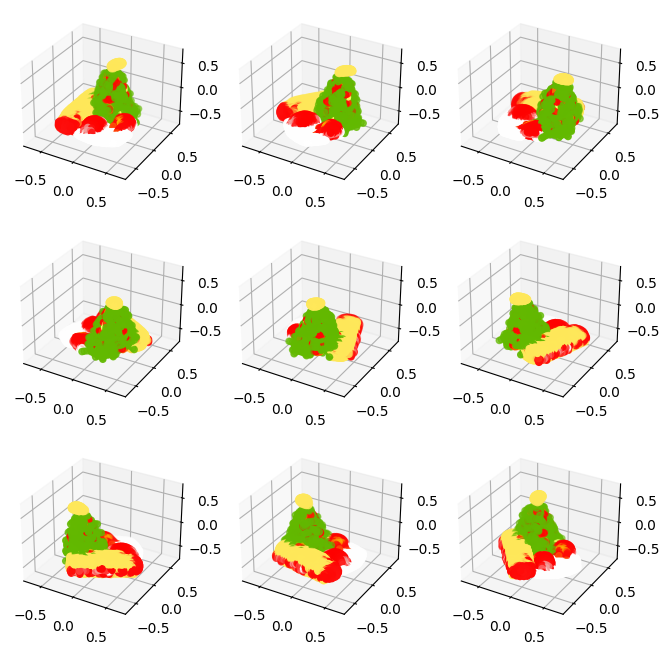

In [12]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))